In [1]:
import pandas as pd
df_term=pd.read_csv('../Data/hiring_data.csv')
df_term['Hire Date'] = pd.to_datetime(df_term['Hire Date'])
df_term['Termination Date'] = pd.to_datetime(df_term['Termination Date'])

df_term['Hire Date Month'] = pd.to_datetime(df_term['Hire Date']).dt.to_period('M')
df_term['Termination Date Month'] = pd.to_datetime(df_term['Termination Date']).dt.to_period('M')

df_term['Hire Date Year'] = pd.to_datetime(df_term['Hire Date']).dt.to_period('Y')
df_term['Termination Date Year'] = pd.to_datetime(df_term['Termination Date']).dt.to_period('Y')

df_term['Full Name']=df_term['First Name'] + '' + df_term['Last Name']

df_hire=pd.read_csv('../Data/turnover_data.csv')


df_hire['Hire Date'] = pd.to_datetime(df_hire['Hire Date'])
df_hire['Hire Date Month'] = pd.to_datetime(df_hire['Hire Date']).dt.to_period('M')



time_series_term=df_term.groupby('Termination Date Month')['Full Name'].count()


time_series_hires=df_term.groupby('Hire Date Month')['Full Name'].count()


time_series_hires=df_hire.groupby('Hire Date Month')['Legal Name'].count()

df_unemployment=pd.read_csv('../Data/umemployment.csv')
df_unemployment.head
df_unemployment.columns  

df_unemployment['DATE'] = pd.to_datetime(df_unemployment['DATE'])
df_unemployment['DATE Month'] = pd.to_datetime(df_unemployment['DATE']).dt.to_period('M')
df_unemployment.set_index('DATE Month',inplace=True)


df_claims=pd.read_csv('../Data/Number_of_claims.csv')
df_claims['DATE Month'] = pd.to_datetime(df_claims['DATE']).dt.to_period('M')
df_claims.set_index('DATE Month',inplace=True)
time_series_claims=df_claims.groupby('DATE Month')['CCSA'].sum()

In [2]:
full_time_series_df_non_un=pd.merge(time_series_term,time_series_hires,how='outer',left_index=True, right_index=True)
full_time_series_df_non_un_1=pd.merge(full_time_series_df_non_un,df_unemployment,how='outer',left_index=True, right_index=True)
full_time_series_df=pd.merge(full_time_series_df_non_un_1,time_series_claims,how='outer',left_index=True, right_index=True)
full_time_series_df.fillna(0,inplace=True)
full_time_series_df.columns=['termination','hires','date','unemployment','claims']

In [3]:
full_time_series_df.columns

Index(['termination', 'hires', 'date', 'unemployment', 'claims'], dtype='object')

In [4]:
full_time_series_df.drop('date',axis=1,inplace=True)
full_time_series_df.drop('claims',axis=1,inplace=True)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=7
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(full_time_series_df, variables = full_time_series_df.columns)    

,termination_x,hires_x,unemployment_x
termination_y,1.0,0.0,0.0
hires_y,0.0,1.0,0.0
unemployment_y,0.0,0.0,1.0


In [7]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(full_time_series_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
termination ::  nan       > 24.2761   =>   False
hires  ::  nan       > 12.3212   =>   False
unemployment ::  5.7       > 4.1296    =>   True


C:\Users\603766\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:674: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
C:\Users\603766\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:676: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1-a[i])


In [8]:
nobs = 4
df_train, df_test = full_time_series_df[0:-nobs], full_time_series_df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(21, 3)
(4, 3)


In [9]:
df_test

,termination,hires,unemployment
Termination Date Month,,,
2020-01,26,7.0,3.6
2020-02,21,4.0,3.5
2020-03,17,3.0,4.4
2020-04,14,3.0,14.7


In [10]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [11]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "termination" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1953
 No. Lags Chosen       = 8
 Critical value 1%     = -4.138
 Critical value 5%     = -3.155
 Critical value 10%    = -2.714
 => P-Value = 0.0203. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "hires" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0533
 No. Lags Chosen       = 0
 Critical value 1%     = -3.809
 Critical value 5%     = -3.022
 Critical value 10%    = -2.651
 => P-Value = 0.0302. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "unemployment" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

In [12]:
model = VAR(df_train)
for i in [1,2,3,4]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  3.7967205071330383
BIC :  4.394159871265433
FPE :  45.29133942125718
HQIC:  3.9133469475709766 

Lag Order = 2
AIC :  3.9807690032721688
BIC :  5.024622611824551
FPE :  59.72868269559337
HQIC:  4.157430507478876 

Lag Order = 3
AIC :  4.444855680935262
BIC :  5.928808610762204
FPE :  130.2963215470511
HQIC:  4.649472780274184 

Lag Order = 4
AIC :  1.7553368279463335
BIC :  3.666826264310595
FPE :  24.82399176611396
HQIC:  1.9453426475012092 



In [13]:
x = model.select_order(maxlags=3)
x.summary()

,AIC,BIC,FPE,HQIC
0,3.592,3.741*,36.34,3.613
1,3.523*,4.117,34.68*,3.605*
2,4.051,5.090,65.40,4.194
3,4.445,5.929,130.3,4.649


In [14]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 13, May, 2020
Time:                     14:09:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    5.02462
Nobs:                     19.0000    HQIC:                   4.15743
Log likelihood:          -97.6968    FPE:                    59.7287
AIC:                      3.98077    Det(Omega_mle):         23.3090
--------------------------------------------------------------------
Results for equation termination
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  24.864994        54.707469            0.455           0.649
L1.termination          0.284258         0.253641            1.121           0.262
L1.hires                0.205313         0.258

In [15]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

2


array([[22. , 11. ,  3.5],
       [15. , 14. ,  3.5]])

In [16]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_test.index[-nobs:], columns=df_train.columns + '_2d')
df_forecast

,termination_2d,hires_2d,unemployment_2d
Termination Date Month,,,
2020-01,19.345204,10.596966,3.543532
2020-02,19.828243,12.623276,3.553733
2020-03,20.475637,11.948193,3.564409
2020-04,20.126021,11.748218,3.568416


In [17]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [18]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['termination_2d', 'hires_2d','unemployment_2d']]

,termination_2d,hires_2d,unemployment_2d
Termination Date Month,,,
2020-01,19.345204,10.596966,3.543532
2020-02,19.828243,12.623276,3.553733
2020-03,20.475637,11.948193,3.564409
2020-04,20.126021,11.748218,3.568416


In [19]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: term')
accuracy_prod = forecast_accuracy(df_results['termination_2d'].values, df_test['termination'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: hire')
accuracy_prod = forecast_accuracy(df_results['hires_2d'].values, df_test['hires'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
    
print('\nForecast Accuracy of: unemployment')
accuracy_prod = forecast_accuracy(df_results['unemployment_2d'].values, df_test['unemployment'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: term
mape :  0.2384
me :  0.4438
mae :  4.3571
mpe :  0.0826
rmse :  4.8803
corr :  -0.857
minmax :  0.1965

Forecast Accuracy of: hire
mape :  2.1421
me :  7.4792
mae :  7.4792
mpe :  2.1421
rmse :  7.8087
corr :  -0.7596
minmax :  0.629

Forecast Accuracy of: unemployment
mape :  0.2445
me :  -2.9925
mae :  3.0193
mpe :  -0.2369
rmse :  5.5816
corr :  0.6928
minmax :  0.2445


In [20]:
nobs = 4
df_train, df_test = full_time_series_df[0:-nobs], full_time_series_df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(21, 3)
(4, 3)


In [21]:
from pydlm import dlm, trend, dynamic,seasonality,autoReg
y=df_train['hires']
x=df_train['termination']
x1=df_train['unemployment']
#x2=df_train['claims']
mydlm = dlm(y)
mydlm = mydlm + trend(degree=0, discount=0.98, name='a', w=10.0)
mydlm = mydlm + dynamic(features=[[v] for v in x], discount=1, name='b', w=10.0)
mydlm = mydlm + dynamic(features=[[v] for v in x1], discount=1, name='c', w=10.0)
#mydlm = mydlm + dynamic(features=[[v] for v in x2], discount=1, name='d', w=10.0)
mdlm = mydlm + seasonality(4, name='4day', w=1.0)
#mydlm = mydlm + autoReg(degree=3, data=full_time_series_df, name='ar3', w=1.0)

In [22]:
mydlm.evolveMode('independent')

In [23]:
mydlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


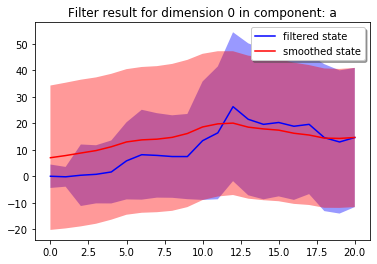

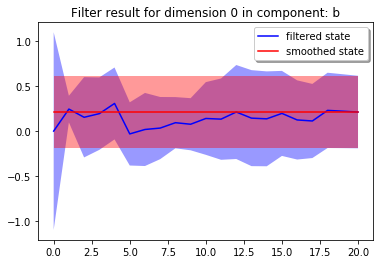

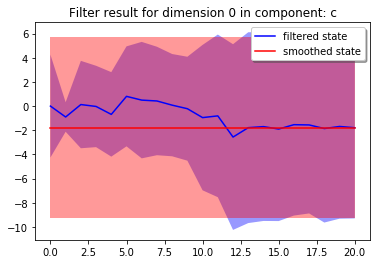

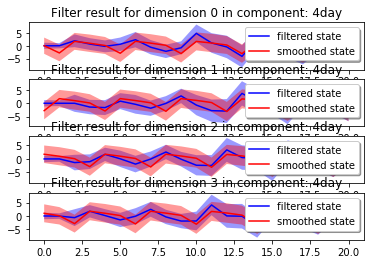

In [24]:
mydlm.turnOff('predict')
mydlm.plotCoef(name='a')
mydlm.plotCoef(name='b')
mydlm.plotCoef(name='c')
#mydlm.plotCoef(name='d')
mydlm.plotCoef(name='4day')

In [25]:
# get the smoothed results
smoothedResult = mydlm.getMean(filterType='backwardSmoother')
smoothedVar = mydlm.getVar(filterType='backwardSmoother')
smoothedCI = mydlm.getInterval(filterType='backwardSmoother')

# get the coefficients
coef_a = mydlm.getLatentState(filterType='backwardSmoother', name='a')
coef_a_var = mydlm.getLatentCov(filterType='backwardSmoother', name='a')
coef_b = mydlm.getLatentState(filterType='backwardSmoother', name='b')
coef_b_var = mydlm.getLatentCov(filterType='backwardSmoother', name='b')
coef_c = mydlm.getLatentState(filterType='backwardSmoother', name='c')
coef_c_var = mydlm.getLatentCov(filterType='backwardSmoother', name='c')
#coef_c = mydlm.getLatentState(filterType='backwardSmoother', name='d')
#coef_c_var = mydlm.getLatentCov(filterType='backwardSmoother', name='d')

In [26]:
mydlm_mse = mydlm.getMSE()
mydlm_mse

52.23248153613347

In [27]:
newData = {'b': df_test['termination'],'c': df_test['unemployment']}
(predictMean, predictVar) = mydlm.predictN(N=4, date=mydlm.n-1, featureDict=newData)

In [28]:
mean_with_simple_test_train=predictMean
mean_with_simple_test_train

[10.646991917690542,
 14.395889234421869,
 11.454231081127727,
 -8.386431387909166]

In [29]:
nobs = 5
df_pre, df_post = full_time_series_df[0:nobs], full_time_series_df[nobs:]

# Check size
print(df_pre.shape)  # (119, 8)
print(df_post.shape)  # (4, 8)

(5, 3)
(20, 3)


In [30]:
nobs = 4
df_train, df_test = df_post[0:-nobs], df_post[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(16, 3)
(4, 3)


In [31]:
y=df_train['hires']
x=df_train['termination']
x1=df_train['unemployment']
#x2=df_train['claims']
mydlm = dlm(y)
mydlm = mydlm + trend(degree=0, discount=0.98, name='a', w=10.0)
mydlm = mydlm + dynamic(features=[[v] for v in x], discount=1, name='b', w=10.0)
mydlm = mydlm + dynamic(features=[[v] for v in x1], discount=1, name='c', w=10.0)
#mydlm = mydlm + dynamic(features=[[v] for v in x2], discount=1, name='d', w=10.0)
mdlm = mydlm + seasonality(4, name='4day', w=1.0)
#mydlm = mydlm + autoReg(degree=3, data=full_time_series_df, name='ar3', w=1.0)

In [32]:
mydlm.evolveMode('independent')

In [33]:
mydlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


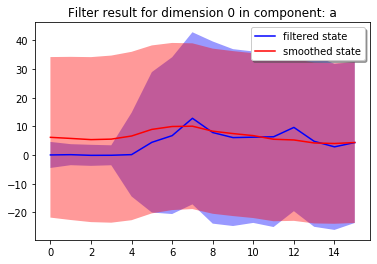

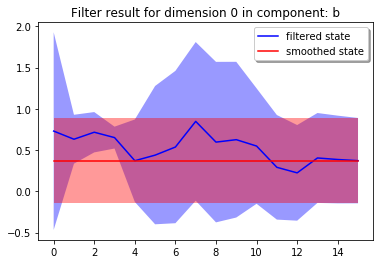

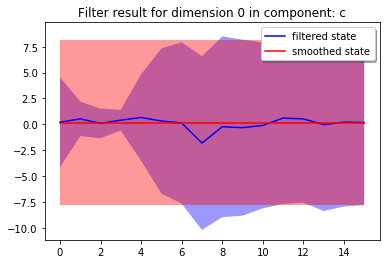

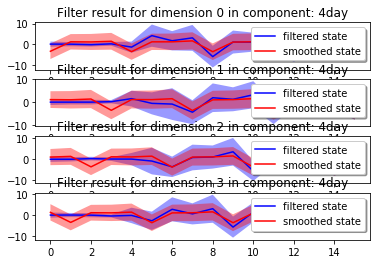

In [34]:
mydlm.turnOff('predict')
mydlm.plotCoef(name='a')
mydlm.plotCoef(name='b')
mydlm.plotCoef(name='c')
#mydlm.plotCoef(name='d')
mydlm.plotCoef(name='4day')

In [35]:
# get the smoothed results
smoothedResult = mydlm.getMean(filterType='backwardSmoother')
smoothedVar = mydlm.getVar(filterType='backwardSmoother')
smoothedCI = mydlm.getInterval(filterType='backwardSmoother')

# get the coefficients
coef_a = mydlm.getLatentState(filterType='backwardSmoother', name='a')
coef_a_var = mydlm.getLatentCov(filterType='backwardSmoother', name='a')
coef_b = mydlm.getLatentState(filterType='backwardSmoother', name='b')
coef_b_var = mydlm.getLatentCov(filterType='backwardSmoother', name='b')
coef_c = mydlm.getLatentState(filterType='backwardSmoother', name='c')
coef_c_var = mydlm.getLatentCov(filterType='backwardSmoother', name='c')
#coef_c = mydlm.getLatentState(filterType='backwardSmoother', name='d')
#coef_c_var = mydlm.getLatentCov(filterType='backwardSmoother', name='d')

In [36]:
mydlm_mse = mydlm.getMSE()
mydlm_mse

67.91798425278981

In [37]:
newData = {'b': df_test['termination'],'c': df_test['unemployment']}
(predictMean, predictVar) = mydlm.predictN(N=4, date=mydlm.n-1, featureDict=newData)

In [38]:
mean_with_restricted_test_train=predictMean
mean_with_restricted_test_train

[11.031785331201993, 13.727915108240218, 12.538620522893467, 13.62031263056355]

In [39]:
nobs = 4
df_train, df_test = full_time_series_df[0:-nobs], full_time_series_df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(21, 3)
(4, 3)


In [40]:
from pydlm import dlm, trend, dynamic,seasonality,autoReg
y=df_train['hires']
x=df_train['termination']
x1=df_train['unemployment']
mydlm = dlm(y)
mydlm = mydlm + trend(degree=0, discount=0.98, name='a', w=10.0)
#mydlm = mydlm + dynamic(features=[[v] for v in x], discount=1, name='b', w=10.0)
mydlm = mydlm + dynamic(features=[[v] for v in x1], discount=1, name='c', w=10.0)
mdlm = mydlm + seasonality(4, name='4day', w=1.0)
#mydlm = mydlm + autoReg(degree=3, data=full_time_series_df, name='ar3', w=1.0)

In [41]:
mydlm.evolveMode('independent')

In [42]:
mydlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


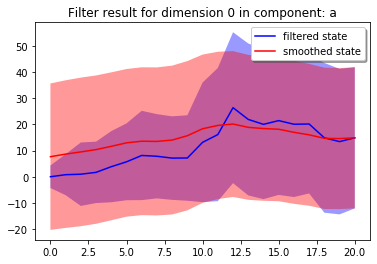

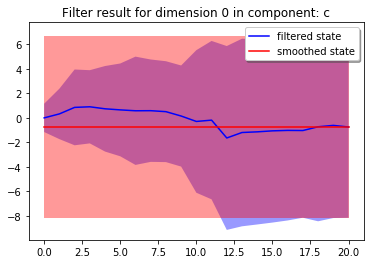

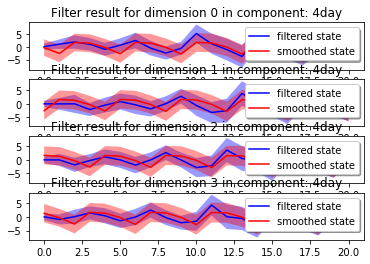

In [43]:
mydlm.turnOff('predict')
mydlm.plotCoef(name='a')
#mydlm.plotCoef(name='b')
mydlm.plotCoef(name='c')
#mydlm.plotCoef(name='d')
mydlm.plotCoef(name='4day')

In [44]:
smoothedResult = mydlm.getMean(filterType='backwardSmoother')
smoothedVar = mydlm.getVar(filterType='backwardSmoother')
smoothedCI = mydlm.getInterval(filterType='backwardSmoother')

# get the coefficients
coef_a = mydlm.getLatentState(filterType='backwardSmoother', name='a')
coef_a_var = mydlm.getLatentCov(filterType='backwardSmoother', name='a')
#coef_b = mydlm.getLatentState(filterType='backwardSmoother', name='b')
#coef_b_var = mydlm.getLatentCov(filterType='backwardSmoother', name='b')
coef_c = mydlm.getLatentState(filterType='backwardSmoother', name='c')
coef_c_var = mydlm.getLatentCov(filterType='backwardSmoother', name='c')
#coef_c = mydlm.getLatentState(filterType='backwardSmoother', name='d')
#coef_c_var = mydlm.getLatentCov(filterType='backwardSmoother', name='d')

In [45]:
mydlm_mse = mydlm.getMSE()
mydlm_mse

50.094884509226155

In [46]:
newData = {'c': df_test['unemployment']}
(predictMean, predictVar) = mydlm.predictN(N=4, date=mydlm.n-1, featureDict=newData)

In [47]:
just_unemployment=predictMean
just_unemployment

[9.346327396388114, 13.701209169653009, 13.066943398829665, 3.8134037263567233]

In [48]:
#this is run before to ensure all values are occur after 9-1-18
nobs = 5
df_pre, df_post = full_time_series_df[0:nobs], full_time_series_df[nobs:]

# Check size
print(df_pre.shape)  # (119, 8)
print(df_post.shape)  # (4, 8)

(5, 3)
(20, 3)


In [49]:
nobs = 4
df_train, df_test = df_post[0:-nobs], df_post[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(16, 3)
(4, 3)


In [50]:
from pydlm import dlm, trend, dynamic,seasonality,autoReg
y=df_train['hires']
x=df_train['termination']
x1=df_train['unemployment']
mydlm = dlm(y)
mydlm = mydlm + trend(degree=0, discount=0.98, name='a', w=10.0)
#mydlm = mydlm + dynamic(features=[[v] for v in x], discount=1, name='b', w=10.0)
mydlm = mydlm + dynamic(features=[[v] for v in x1], discount=1, name='c', w=10.0)
mdlm = mydlm + seasonality(4, name='4day', w=1.0)
#mydlm = mydlm + autoReg(degree=3, data=full_time_series_df, name='ar3', w=1.0)

In [51]:
mydlm.evolveMode('independent')

In [52]:
mydlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


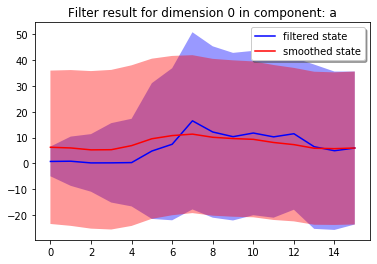

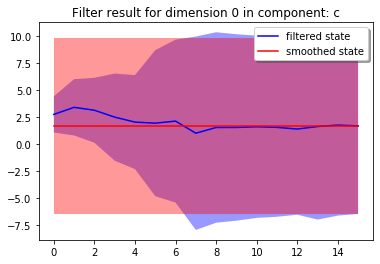

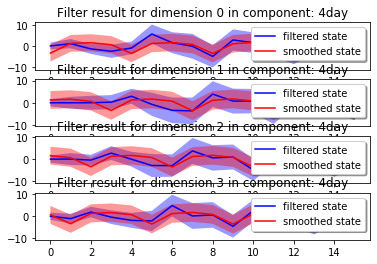

In [53]:
mydlm.turnOff('predict')
mydlm.plotCoef(name='a')
#mydlm.plotCoef(name='b')
mydlm.plotCoef(name='c')
#mydlm.plotCoef(name='d')
mydlm.plotCoef(name='4day')

In [54]:
smoothedResult = mydlm.getMean(filterType='backwardSmoother')
smoothedVar = mydlm.getVar(filterType='backwardSmoother')
smoothedCI = mydlm.getInterval(filterType='backwardSmoother')

# get the coefficients
coef_a = mydlm.getLatentState(filterType='backwardSmoother', name='a')
coef_a_var = mydlm.getLatentCov(filterType='backwardSmoother', name='a')
#coef_b = mydlm.getLatentState(filterType='backwardSmoother', name='b')
#coef_b_var = mydlm.getLatentCov(filterType='backwardSmoother', name='b')
coef_c = mydlm.getLatentState(filterType='backwardSmoother', name='c')
coef_c_var = mydlm.getLatentCov(filterType='backwardSmoother', name='c')
#coef_c = mydlm.getLatentState(filterType='backwardSmoother', name='d')
#coef_c_var = mydlm.getLatentCov(filterType='backwardSmoother', name='d')

In [55]:
mydlm_mse = mydlm.getMSE()
mydlm_mse

69.43665968634023

In [56]:
newData = {'c': df_test['unemployment']}
(predictMean, predictVar) = mydlm.predictN(N=4, date=mydlm.n-1, featureDict=newData)

In [57]:
just_unemployment_prev=predictMean
just_unemployment_prev

[8.447888889177914, 12.838891735540859, 15.014797111406946, 31.33264039670898]

In [58]:
var=np.array(df_results['hires_2d'])

In [59]:
var

array([10.59696554, 12.62327575, 11.94819318, 11.748218  ])

In [60]:
final_frame_early=pd.DataFrame({'actual_values':df_test['hires'],'all_data_unemployment':mean_with_simple_test_train,'post_september':mean_with_restricted_test_train,'just_unemployment':just_unemployment,'just_unemployment_prev':just_unemployment_prev,'VAR output':var})

In [61]:
df_unemployment=pd.read_csv('../Data/unemployment_test_data.csv')
df_unemployment.head
df_unemployment.columns  

Index(['Date', 'unemployment_test'], dtype='object')

In [62]:
df_unemployment['Date'] = pd.to_datetime(df_unemployment['Date'])
df_unemployment['DATE Month'] = pd.to_datetime(df_unemployment['Date']).dt.to_period('M')
df_unemployment.set_index('DATE Month',inplace=True)

In [63]:
from pydlm import dlm, trend, dynamic,seasonality,autoReg
y=full_time_series_df['hires']
x=full_time_series_df['termination']
x1=full_time_series_df['unemployment']
mydlm = dlm(y)
mydlm = mydlm + trend(degree=0, discount=0.98, name='a', w=10.0)
#mydlm = mydlm + dynamic(features=[[v] for v in x], discount=1, name='b', w=10.0)
mydlm = mydlm + dynamic(features=[[v] for v in x1], discount=1, name='c', w=10.0)
mdlm = mydlm + seasonality(4, name='4day', w=1.0)
#mydlm = mydlm + autoReg(degree=3, data=full_time_series_df, name='ar3', w=1.0)

In [64]:
mydlm.evolveMode('independent')

In [65]:
mydlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [66]:
# get the smoothed results
smoothedResult = mydlm.getMean(filterType='backwardSmoother')
smoothedVar = mydlm.getVar(filterType='backwardSmoother')
smoothedCI = mydlm.getInterval(filterType='backwardSmoother')

# get the coefficients
coef_a = mydlm.getLatentState(filterType='backwardSmoother', name='a')
coef_a_var = mydlm.getLatentCov(filterType='backwardSmoother', name='a')
#coef_b = mydlm.getLatentState(filterType='backwardSmoother', name='b')
#coef_b_var = mydlm.getLatentCov(filterType='backwardSmoother', name='b')
coef_c = mydlm.getLatentState(filterType='backwardSmoother', name='c')
coef_c_var = mydlm.getLatentCov(filterType='backwardSmoother', name='c')

In [67]:
mydlm_mse = mydlm.getMSE()
mydlm_mse

63.44624432545631

In [68]:
newData = {'c': df_unemployment['unemployment_test']}
(predictMean, predictVar) = mydlm.predictN(N=5, date=mydlm.n-1, featureDict=newData)

In [69]:
just_unemployment_prev=predictMean
just_unemployment_prev

[-0.5675683314896585,
 2.4566275177799994,
 3.1981390840370008,
 3.290247341622435,
 0.9308565818844583]

In [70]:
#this is run before to ensure all values are occur after 9-1-18
nobs = 5
df_pre, df_post = full_time_series_df[0:nobs], full_time_series_df[nobs:]

# Check size
print(df_pre.shape)  # (119, 8)
print(df_post.shape)  # (4, 8)

(5, 3)
(20, 3)


In [71]:
y=df_post['hires']
x=df_post['termination']
x1=df_post['unemployment']
mydlm = dlm(y)
mydlm = mydlm + trend(degree=0, discount=0.98, name='a', w=10.0)
#mydlm = mydlm + dynamic(features=[[v] for v in x], discount=1, name='b', w=10.0)
mydlm = mydlm + dynamic(features=[[v] for v in x1], discount=1, name='c', w=10.0)
mdlm = mydlm + seasonality(4, name='4day', w=1.0)
#mydlm = mydlm + autoReg(degree=3, data=full_time_series_df, name='ar3', w=1.0)

In [72]:
mydlm.evolveMode('independent')

In [73]:
mydlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [74]:
# get the smoothed results
smoothedResult = mydlm.getMean(filterType='backwardSmoother')
smoothedVar = mydlm.getVar(filterType='backwardSmoother')
smoothedCI = mydlm.getInterval(filterType='backwardSmoother')

# get the coefficients
coef_a = mydlm.getLatentState(filterType='backwardSmoother', name='a')
coef_a_var = mydlm.getLatentCov(filterType='backwardSmoother', name='a')
#coef_b = mydlm.getLatentState(filterType='backwardSmoother', name='b')
#coef_b_var = mydlm.getLatentCov(filterType='backwardSmoother', name='b')
coef_c = mydlm.getLatentState(filterType='backwardSmoother', name='c')
coef_c_var = mydlm.getLatentCov(filterType='backwardSmoother', name='c')

In [75]:
mydlm_mse = mydlm.getMSE()
mydlm_mse

63.64199949126046

In [76]:
newData = {'c': df_unemployment['unemployment_test']}
(predictMean, predictVar) = mydlm.predictN(N=5, date=mydlm.n-1, featureDict=newData)

In [77]:
mean_post_september_2018=predictMean
mean_post_september_2018

[-1.6716708814130143,
 1.4860079729543854,
 2.72761752202394,
 3.694877330708535,
 -0.0752637783876473]

In [78]:
final_frame_early

,actual_values,all_data_unemployment,post_september,just_unemployment,just_unemployment_prev,VAR output
Termination Date Month,,,,,,
2020-01,7.0,10.646992,11.031785,9.346327,8.447889,10.596966
2020-02,4.0,14.395889,13.727915,13.701209,12.838892,12.623276
2020-03,3.0,11.454231,12.538621,13.066943,15.014797,11.948193
2020-04,3.0,-8.386431,13.620313,3.813404,31.332640,11.748218


In [79]:
import numpy as np
all_data=[10,14,14,4,0,3,4,4,1]
post=[9,13,16,32,2,2,3,4,0]
all_data_term=[11,15,12,0,np.nan,np.nan,np.nan,np.nan,np.nan]
post_w_vars=[12,14,13,14,np.nan,np.nan,np.nan,np.nan,np.nan]
var_model=[10,13,12,12,np.nan,np.nan,np.nan,np.nan,np.nan]


df_forecast_values=pd.DataFrame({'includes unemployment':all_data,'includes unemployment post':post,'includes term':all_data_term,'includes term post':post_w_vars,'VAR model':var_model})

In [80]:
all_data_term=[11,15,12,0]
post_w_vars=[12,14,13,14]
var_model=[10,13,12,12]


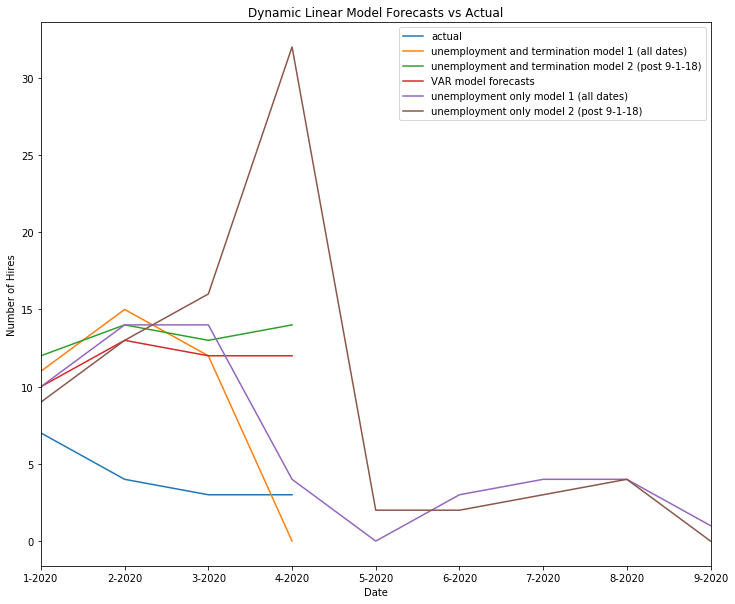

In [81]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
plt.figure(figsize=(12,10))
#plt.plot(['5-2020', '6-2020', '7-2020', '8-2020','9-2020'],final_frame['actual_values'],label='actual')
plt.plot(['1-2020', '2-2020', '3-2020', '4-2020'],final_frame_early['actual_values'],label='actual')
plt.plot(['1-2020', '2-2020', '3-2020', '4-2020'],all_data_term, label='unemployment and termination model 1 (all dates)')
plt.plot(['1-2020', '2-2020', '3-2020', '4-2020'], post_w_vars,label='unemployment and termination model 2 (post 9-1-18)')
plt.plot(['1-2020', '2-2020', '3-2020', '4-2020'], var_model,label='VAR model forecasts')
plt.plot(['1-2020', '2-2020', '3-2020', '4-2020','5-2020', '6-2020', '7-2020', '8-2020','9-2020'],all_data, label='unemployment only model 1 (all dates)')
plt.plot(['1-2020', '2-2020', '3-2020', '4-2020','5-2020', '6-2020', '7-2020', '8-2020','9-2020'], post,label='unemployment only model 2 (post 9-1-18)')
plt.xlabel("Date")
plt.ylabel("Number of Hires")
plt.title("Dynamic Linear Model Forecasts vs Actual")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('final_forecasts.png')